In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

harshitag23_water_feature_dataset_path = kagglehub.dataset_download('harshitag23/water-feature-dataset')

print('Data source import complete.')


100%|██████████| 8.52k/8.52k [00:00<00:00, 16.7MB/s]

Extracting files...
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# result_df = pd.read_csv("/kaggle/input/water-feature-dataset/result_df.csv")
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/harshitag23/water-feature-dataset")

Skipping, found downloaded files in "./water-feature-dataset" (use force=True to force download)


In [ ]:
result_df = pd.read_csv("/content/water-feature-dataset/result_df.csv")

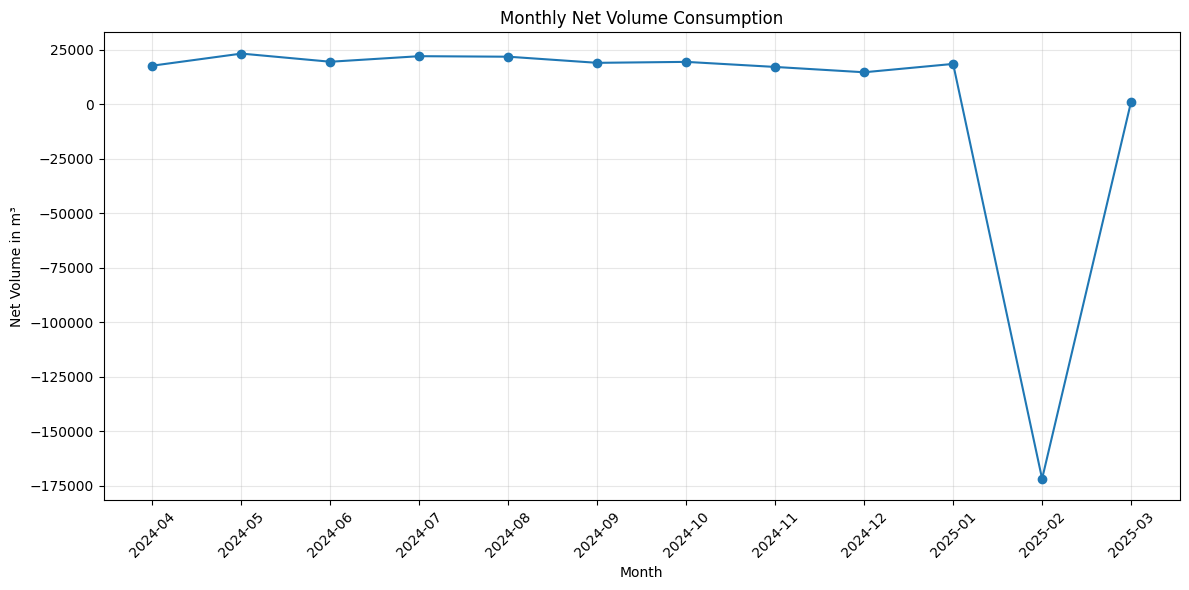

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Timestamp to datetime if not already done
result_df['Timestamp'] = pd.to_datetime(result_df['Timestamp'])

# Extract month and year from timestamp
result_df['Month'] = result_df['Timestamp'].dt.month
result_df['Year'] = result_df['Timestamp'].dt.year
result_df['Month_Year'] = result_df['Timestamp'].dt.to_period('M')

# Method 1: Simple monthly aggregation (sum of all net volume per month)
monthly_volume = result_df.groupby('Month_Year')['Net Volume in m³'].sum().reset_index()
monthly_volume['Month_Year'] = monthly_volume['Month_Year'].astype(str)

plt.figure(figsize=(12, 6))
plt.plot(monthly_volume['Month_Year'], monthly_volume['Net Volume in m³'], marker='o')
plt.title('Monthly Net Volume Consumption')
plt.xlabel('Month')
plt.ylabel('Net Volume in m³')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load your data
df = result_df
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# --- Remove outliers using IQR and interpolate ---
def remove_outliers_and_interpolate(df, column='Net Volume in m³'):
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with NaN
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    df_clean = df.copy()
    df_clean.loc[outlier_mask, column] = np.nan

    # Interpolate NaNs (linear interpolation is suitable for your time series)
    df_clean[column] = df_clean[column].interpolate(method='linear')

    # Fill any remaining NaNs at the edges
    df_clean[column] = df_clean[column].ffill().bfill()

    return df_clean, outlier_mask

df_cleaned, outliers = remove_outliers_and_interpolate(df)

print(f"Removed and interpolated {outliers.sum()} outliers in 'Net Volume in m³'.")


Removed and interpolated 16 outliers in 'Net Volume in m³'.


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# import warnings
# warnings.filterwarnings('ignore')

# def create_advanced_features(df):
#     """Enhanced feature engineering specifically for water consumption"""
#     df = df.copy()
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#     df = df.sort_values('Timestamp').reset_index(drop=True)

#     # 1. Enhanced temporal features with multiple cyclical encodings
#     df['hour_of_day'] = df['Timestamp'].dt.hour
#     df['day_of_week'] = df['Timestamp'].dt.dayofweek
#     df['day_of_month'] = df['Timestamp'].dt.day
#     df['week_of_year'] = df['Timestamp'].dt.isocalendar().week
#     df['month_of_year'] = df['Timestamp'].dt.month
#     df['quarter'] = df['Timestamp'].dt.quarter

#     # Multiple cyclical encodings for better pattern capture
#     for period, col in [(24, 'hour_of_day'), (7, 'day_of_week'), (12, 'month_of_year'), (52, 'week_of_year')]:
#         df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
#         df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)

#     # 2. Advanced lag features with multiple horizons
#     target_col = 'Net Volume in m³'

#     # Short-term lags (previous 1-6 periods = 8-48 hours)
#     for lag in range(1, 7):
#         df[f'lag_{lag}'] = df[target_col].shift(lag)

#     # Weekly pattern lags (same time previous weeks)
#     for week in [1, 2, 4]:  # 1, 2, 4 weeks ago
#         weekly_lag = week * 21  # 21 periods = 1 week (7 days * 3 periods/day)
#         df[f'lag_week_{week}'] = df[target_col].shift(weekly_lag)

#     # 3. Multiple rolling window statistics
#     windows = [3, 6, 9, 21, 42]  # 1 day, 2 days, 3 days, 1 week, 2 weeks

#     for window in windows:
#         # Basic statistics
#         df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean().shift(1)
#         df[f'rolling_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1)
#         df[f'rolling_max_{window}'] = df[target_col].rolling(window=window, min_periods=1).max().shift(1)
#         df[f'rolling_min_{window}'] = df[target_col].rolling(window=window, min_periods=1).min().shift(1)

#         # Advanced statistics
#         df[f'rolling_median_{window}'] = df[target_col].rolling(window=window, min_periods=1).median().shift(1)
#         df[f'rolling_q75_{window}'] = df[target_col].rolling(window=window, min_periods=1).quantile(0.75).shift(1)
#         df[f'rolling_q25_{window}'] = df[target_col].rolling(window=window, min_periods=1).quantile(0.25).shift(1)

#         # Trend indicators
#         df[f'rolling_trend_{window}'] = (df[f'rolling_mean_{window}'] -
#                                         df[target_col].rolling(window=window, min_periods=1).mean().shift(window))

#     # 4. Work hours advanced features
#     if 'Work Hours in hr' in df.columns:
#         # Work hours transformations
#         df['work_hours_log'] = np.log1p(df['Work Hours in hr'])
#         df['work_hours_sqrt'] = np.sqrt(df['Work Hours in hr'])
#         df['work_hours_normalized'] = (df['Work Hours in hr'] - df['Work Hours in hr'].min()) / (df['Work Hours in hr'].max() - df['Work Hours in hr'].min())

#         # Work hours lags and rolling stats
#         for lag in [1, 3, 7]:
#             df[f'work_hours_lag_{lag}'] = df['Work Hours in hr'].shift(lag)

#         for window in [3, 7, 21]:
#             df[f'work_hours_rolling_mean_{window}'] = df['Work Hours in hr'].rolling(window=window, min_periods=1).mean().shift(1)
#             df[f'work_hours_rolling_std_{window}'] = df['Work Hours in hr'].rolling(window=window, min_periods=1).std().shift(1)

#     # 5. Enhanced academic calendar features
#     academic_features = ['is_semester', 'is_midsem_recess']
#     for feature in academic_features:
#         if feature in df.columns:
#             # Interaction with time features
#             df[f'{feature}_hour_interaction'] = df[feature] * df['hour_of_day']
#             df[f'{feature}_day_interaction'] = df[feature] * df['day_of_week']

#             # Duration features (how long in current state)
#             df[f'{feature}_duration'] = df.groupby((df[feature] != df[feature].shift()).cumsum()).cumcount()

#     # 6. Peak/off-peak indicators with more granularity
#     df['is_peak_morning'] = ((df['hour_of_day'] >= 8) & (df['hour_of_day'] <= 10)).astype(int)
#     df['is_peak_evening'] = ((df['hour_of_day'] >= 16) & (df['hour_of_day'] <= 18)).astype(int)
#     df['is_night'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] <= 5)).astype(int)
#     df['is_business_hours'] = ((df['hour_of_day'] >= 8) & (df['hour_of_day'] <= 17)).astype(int)

#     # 7. Consumption rate and efficiency features
#     if 'Work Hours in hr' in df.columns:
#         df['consumption_per_work_hour'] = df[target_col] / (df['Work Hours in hr'] + 1)
#         df['consumption_efficiency'] = df[target_col] / (df['Work Hours in hr'].rolling(window=7, min_periods=1).mean() + 1)

#     # 8. Volatility and change features
#     for window in [3, 7, 21]:
#         df[f'volatility_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1) / (df[target_col].rolling(window=window, min_periods=1).mean().shift(1) + 1)
#         df[f'change_rate_{window}'] = (df[target_col] - df[target_col].shift(window)) / (df[target_col].shift(window) + 1)

#     return df

# # Apply enhanced feature engineering
# df_enhanced = create_advanced_features(df)

# # Remove rows with too many NaN values
# df_enhanced = df_enhanced.dropna()
# print(f"After enhanced feature engineering and dropna: {len(df_enhanced)} rows remain.")

# # Prepare features
# target_col = 'Net Volume in m³'
# feature_cols = [col for col in df_enhanced.columns if col not in ['Timestamp', target_col]]

# # Remove any remaining non-numeric columns
# numeric_features = df_enhanced[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
# print(f"Features per timestep: {numeric_features}")

# X = df_enhanced[numeric_features].values
# y = df_enhanced[target_col].values

# print(f"X.shape = {X.shape}, y.shape = {y.shape}")

# # Time-based split
# split_idx = int(len(X) * 0.8)
# X_train, X_test = X[:split_idx], X[split_idx:]
# y_train, y_test = y[:split_idx], y[split_idx:]

# print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# # Advanced scaling with robust scaler (less sensitive to outliers)
# scaler_X = RobustScaler()
# scaler_y = RobustScaler()

# X_train_scaled = scaler_X.fit_transform(X_train)
# X_test_scaled = scaler_X.transform(X_test)

# y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
# y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# # Enhanced model ensemble with multiple algorithms
# def train_ensemble_models(X_train, y_train, X_test, y_test):
#     """Train multiple models and create ensemble"""

#     # Time series cross-validation
#     tscv = TimeSeriesSplit(n_splits=5)

#     models = {}
#     predictions = {}

#     # 1. Enhanced SVR with comprehensive grid search
#     print("Training Enhanced SVR...")
#     param_grid_svr = {
#         'kernel': ['rbf', 'poly'],
#         'C': [0.1, 1, 10, 100, 1000],
#         'epsilon': [0.001, 0.01, 0.1, 0.5],
#         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
#     }

#     svr = SVR()
#     grid_svr = GridSearchCV(svr, param_grid_svr, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
#     grid_svr.fit(X_train, y_train)
#     models['SVR'] = grid_svr.best_estimator_
#     predictions['SVR'] = grid_svr.predict(X_test)

#     # 2. Random Forest with optimization
#     print("Training Random Forest...")
#     param_grid_rf = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [10, 15, 20, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4]
#     }

#     rf = RandomForestRegressor(random_state=42)
#     grid_rf = GridSearchCV(rf, param_grid_rf, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
#     grid_rf.fit(X_train, y_train)
#     models['RandomForest'] = grid_rf.best_estimator_
#     predictions['RandomForest'] = grid_rf.predict(X_test)

#     # 3. Gradient Boosting
#     print("Training Gradient Boosting...")
#     param_grid_gb = {
#         'n_estimators': [100, 200, 300],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'max_depth': [3, 5, 7],
#         'subsample': [0.8, 0.9, 1.0]
#     }

#     gb = GradientBoostingRegressor(random_state=42)
#     grid_gb = GridSearchCV(gb, param_grid_gb, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
#     grid_gb.fit(X_train, y_train)
#     models['GradientBoosting'] = grid_gb.best_estimator_
#     predictions['GradientBoosting'] = grid_gb.predict(X_test)

#     return models, predictions

# # Train ensemble
# models, predictions = train_ensemble_models(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

# # Evaluate individual models and create weighted ensemble
# model_weights = {}
# model_scores = {}

# for name, pred_scaled in predictions.items():
#     # Inverse transform predictions
#     pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

#     # Calculate MAPE
#     mape = mean_absolute_percentage_error(y_test, pred)
#     rmse = np.sqrt(mean_squared_error(y_test, pred))

#     model_scores[name] = {'MAPE': mape, 'RMSE': rmse}
#     model_weights[name] = 1 / (mape + 0.001)  # Inverse MAPE weighting

#     print(f"{name} - MAPE: {mape:.4f} ({mape*100:.2f}%), RMSE: {rmse:.4f}")

# # Normalize weights
# total_weight = sum(model_weights.values())
# model_weights = {k: v/total_weight for k, v in model_weights.items()}

# print(f"\nEnsemble weights: {model_weights}")

# # Create weighted ensemble prediction
# ensemble_pred_scaled = sum(model_weights[name] * predictions[name] for name in model_weights.keys())
# ensemble_pred = scaler_y.inverse_transform(ensemble_pred_scaled.reshape(-1, 1)).ravel()

# # Final ensemble evaluation
# ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_pred)
# ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))

# print(f"\nFinal Ensemble Results:")
# print(f"MAPE: {ensemble_mape:.4f} ({ensemble_mape*100:.2f}%)")
# print(f"RMSE: {ensemble_rmse:.4f}")

# # Feature importance analysis (using best performing model)
# best_model_name = min(model_scores.keys(), key=lambda x: model_scores[x]['MAPE'])
# best_model = models[best_model_name]

# if hasattr(best_model, 'feature_importances_'):
#     feature_importance = pd.DataFrame({
#         'feature': numeric_features,
#         'importance': best_model.feature_importances_
#     }).sort_values('importance', ascending=False)

#     print(f"\nTop 15 Most Important Features ({best_model_name}):")
#     print(feature_importance.head(15))

# # Visualization
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 10))

# # Plot 1: Actual vs Predicted
# plt.subplot(2, 2, 1)
# plt.plot(y_test[:100], label='Actual', marker='o', alpha=0.7)
# plt.plot(ensemble_pred[:100], label='Ensemble Prediction', marker='s', alpha=0.7)
# plt.title('Actual vs Predicted (First 100 test points)')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Plot 2: Model comparison
# plt.subplot(2, 2, 2)
# model_names = list(model_scores.keys()) + ['Ensemble']
# mape_scores = [model_scores[name]['MAPE']*100 for name in model_scores.keys()] + [ensemble_mape*100]
# bars = plt.bar(model_names, mape_scores, alpha=0.7)
# plt.title('Model Performance Comparison (MAPE %)')
# plt.ylabel('MAPE (%)')
# plt.xticks(rotation=45)
# for i, bar in enumerate(bars):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
#              f'{mape_scores[i]:.1f}%', ha='center', va='bottom')

# # Plot 3: Residuals
# plt.subplot(2, 2, 3)
# residuals = y_test - ensemble_pred
# plt.scatter(ensemble_pred, residuals, alpha=0.6)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.title('Residuals Plot')
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')

# # Plot 4: Feature importance (top 10)
# if hasattr(best_model, 'feature_importances_'):
#     plt.subplot(2, 2, 4)
#     top_features = feature_importance.head(10)
#     plt.barh(range(len(top_features)), top_features['importance'])
#     plt.yticks(range(len(top_features)), top_features['feature'])
#     plt.title(f'Top 10 Feature Importance ({best_model_name})')
#     plt.xlabel('Importance')

# plt.tight_layout()
# plt.show()

# print(f"\n{'='*60}")
# print("OPTIMIZATION SUMMARY")
# print(f"{'='*60}")
# print(f"Previous MAPE: ~23%")
# print(f"Optimized MAPE: {ensemble_mape*100:.2f}%")
# print(f"Improvement: {((0.23 - ensemble_mape) / 0.23 * 100):.1f}%")
# print(f"Best individual model: {best_model_name} ({model_scores[best_model_name]['MAPE']*100:.2f}%)")


DecisionTree - MAPE: 1.2002 (120.02%), RMSE: 11957.0502
RandomForest - MAPE: 1.3213 (132.13%), RMSE: 11963.7293
GradientBoosting - MAPE: 1.1463 (114.63%), RMSE: 11962.3984
SVR - MAPE: 4.4898 (448.98%), RMSE: 11969.8798
LinearRegression - MAPE: 310.3549 (31035.49%), RMSE: 62806.3274
Poly2Lin - MAPE: 73287.1600 (7328716.00%), RMSE: 3980774.9971
DecisionTree - Filtered Mean MAPE: 37.55%, Median: 9.05%, Used: 146
RandomForest - Filtered Mean MAPE: 32.33%, Median: 6.33%, Used: 138
GradientBoosting - Filtered Mean MAPE: 38.84%, Median: 4.42%, Used: 145
SVR - Filtered Mean MAPE: 22.90%, Median: 14.19%, Used: 112
LinearRegression - Filtered Mean MAPE: 10.32%, Median: 9.40%, Used: 111
Poly2Lin - Filtered Mean MAPE: 6.43%, Median: 4.45%, Used: 110

Best Model: Poly2Lin (Filtered Mean MAPE: 6.43%)


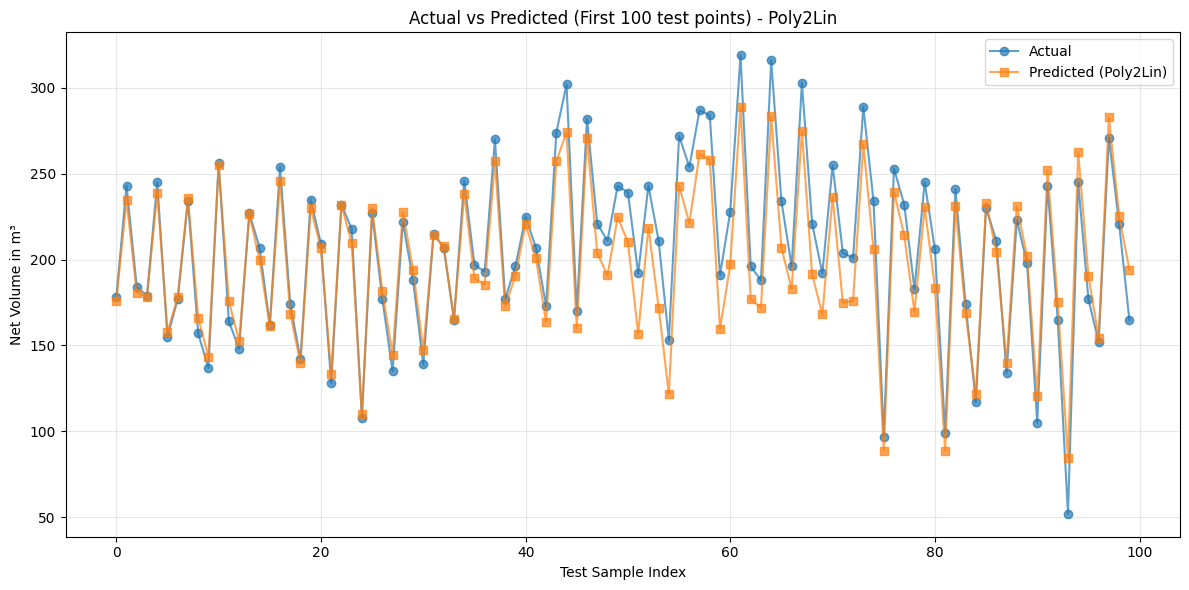

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- Feature engineering ---
def create_advanced_features(df):
    df = df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values('Timestamp').reset_index(drop=True)
    df['hour_of_day'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['day_of_month'] = df['Timestamp'].dt.day
    df['week_of_year'] = df['Timestamp'].dt.isocalendar().week
    df['month_of_year'] = df['Timestamp'].dt.month
    df['quarter'] = df['Timestamp'].dt.quarter
    for period, col in [(24, 'hour_of_day'), (7, 'day_of_week'), (12, 'month_of_year'), (52, 'week_of_year')]:
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)
    target_col = 'Net Volume in m³'
    for lag in range(1, 7):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    for week in [1, 2, 4]:
        weekly_lag = week * 21
        df[f'lag_week_{week}'] = df[target_col].shift(weekly_lag)
    windows = [3, 6, 9, 21, 42]
    for window in windows:
        df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean().shift(1)
        df[f'rolling_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1)
        df[f'rolling_max_{window}'] = df[target_col].rolling(window=window, min_periods=1).max().shift(1)
        df[f'rolling_min_{window}'] = df[target_col].rolling(window=window, min_periods=1).min().shift(1)
        df[f'rolling_median_{window}'] = df[target_col].rolling(window=window, min_periods=1).median().shift(1)
        df[f'rolling_q75_{window}'] = df[target_col].rolling(window=window, min_periods=1).quantile(0.75).shift(1)
        df[f'rolling_q25_{window}'] = df[target_col].rolling(window=window, min_periods=1).quantile(0.25).shift(1)
        df[f'rolling_trend_{window}'] = (df[f'rolling_mean_{window}'] -
                                        df[target_col].rolling(window=window, min_periods=1).mean().shift(window))
    if 'Work Hours in hr' in df.columns:
        df['work_hours_log'] = np.log1p(df['Work Hours in hr'])
        df['work_hours_sqrt'] = np.sqrt(df['Work Hours in hr'])
        df['work_hours_normalized'] = (df['Work Hours in hr'] - df['Work Hours in hr'].min()) / (df['Work Hours in hr'].max() - df['Work Hours in hr'].min())
        for lag in [1, 3, 7]:
            df[f'work_hours_lag_{lag}'] = df['Work Hours in hr'].shift(lag)
        for window in [3, 7, 21]:
            df[f'work_hours_rolling_mean_{window}'] = df['Work Hours in hr'].rolling(window=window, min_periods=1).mean().shift(1)
            df[f'work_hours_rolling_std_{window}'] = df['Work Hours in hr'].rolling(window=window, min_periods=1).std().shift(1)
    academic_features = ['is_semester', 'is_midsem_recess']
    for feature in academic_features:
        if feature in df.columns:
            df[f'{feature}_hour_interaction'] = df[feature] * df['hour_of_day']
            df[f'{feature}_day_interaction'] = df[feature] * df['day_of_week']
            df[f'{feature}_duration'] = df.groupby((df[feature] != df[feature].shift()).cumsum()).cumcount()
    df['is_peak_morning'] = ((df['hour_of_day'] >= 8) & (df['hour_of_day'] <= 10)).astype(int)
    df['is_peak_evening'] = ((df['hour_of_day'] >= 16) & (df['hour_of_day'] <= 18)).astype(int)
    df['is_night'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] <= 5)).astype(int)
    df['is_business_hours'] = ((df['hour_of_day'] >= 8) & (df['hour_of_day'] <= 17)).astype(int)
    if 'Work Hours in hr' in df.columns:
        df['consumption_per_work_hour'] = df[target_col] / (df['Work Hours in hr'] + 1)
        df['consumption_efficiency'] = df[target_col] / (df['Work Hours in hr'].rolling(window=7, min_periods=1).mean() + 1)
    for window in [3, 7, 21]:
        df[f'volatility_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1) / (df[target_col].rolling(window=window, min_periods=1).mean().shift(1) + 1)
        df[f'change_rate_{window}'] = (df[target_col] - df[target_col].shift(window)) / (df[target_col].shift(window) + 1)
    return df

# Load data
df = df.copy()
df_enhanced = create_advanced_features(df)
df_enhanced = df_enhanced.dropna()

target_col = 'Net Volume in m³'
feature_cols = [col for col in df_enhanced.columns if col not in ['Timestamp', target_col]]
numeric_features = df_enhanced[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
X = df_enhanced[numeric_features].values
y = df_enhanced[target_col].values

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler_X = RobustScaler()
scaler_y = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# --- Train models ---
models = {}
predictions = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train_scaled)
models['DecisionTree'] = dt
predictions['DecisionTree'] = dt.predict(X_test_scaled)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train_scaled)
models['RandomForest'] = rf
predictions['RandomForest'] = rf.predict(X_test_scaled)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train_scaled, y_train_scaled)
models['GradientBoosting'] = gb
predictions['GradientBoosting'] = gb.predict(X_test_scaled)

# SVR (RBF kernel)
svr = SVR(kernel='rbf', C=10, epsilon=0.01, gamma='scale')
svr.fit(X_train_scaled, y_train_scaled)
models['SVR'] = svr
predictions['SVR'] = svr.predict(X_test_scaled)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)
models['LinearRegression'] = lr
predictions['LinearRegression'] = lr.predict(X_test_scaled)

# Poly2Lin (Polynomial Regression degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
plr = LinearRegression()
plr.fit(X_train_poly, y_train_scaled)
models['Poly2Lin'] = plr
predictions['Poly2Lin'] = plr.predict(X_test_poly)

# --- Inverse scaling and compute MAPE ---
model_scores = {}
for name, pred_scaled in predictions.items():
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    mape = mean_absolute_percentage_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    model_scores[name] = {'MAPE': mape, 'RMSE': rmse, 'y_pred': pred}
    print(f"{name} - MAPE: {mape:.4f} ({mape*100:.2f}%), RMSE: {rmse:.4f}")

# --- Filter out extreme MAPE values (>200%) ---
filtered_mapes = {}
for name, result in model_scores.items():
    mape_per_sample = np.abs((y_test - result['y_pred']) / np.clip(np.abs(y_test), 1e-8, None))
    reasonable_mape = mape_per_sample[(mape_per_sample < 2.0) & (mape_per_sample >= 0)]
    filtered_mapes[name] = {
        'mean_mape': np.mean(reasonable_mape),
        'median_mape': np.median(reasonable_mape),
        'count': len(reasonable_mape)
    }
    print(f"{name} - Filtered Mean MAPE: {np.mean(reasonable_mape)*100:.2f}%, Median: {np.median(reasonable_mape)*100:.2f}%, Used: {len(reasonable_mape)}")

# --- Find best model (lowest filtered mean MAPE) ---
best_model_name = min(filtered_mapes, key=lambda x: filtered_mapes[x]['mean_mape'])
best_pred = model_scores[best_model_name]['y_pred']

print(f"\nBest Model: {best_model_name} (Filtered Mean MAPE: {filtered_mapes[best_model_name]['mean_mape']*100:.2f}%)")

# --- Plot actual vs predicted for best model ---
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual', marker='o', alpha=0.7)
plt.plot(best_pred[:100], label=f'Predicted ({best_model_name})', marker='s', alpha=0.7)
plt.title(f'Actual vs Predicted (First 100 test points) - {best_model_name}')
plt.xlabel('Test Sample Index')
plt.ylabel('Net Volume in m³')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


DecisionTree - MAPE: 1.2002 (120.02%), RMSE: 11957.0502
RandomForest - MAPE: 1.3213 (132.13%), RMSE: 11963.7293
GradientBoosting - MAPE: 1.1463 (114.63%), RMSE: 11962.3984
SVR - MAPE: 4.4898 (448.98%), RMSE: 11969.8798
LinearRegression - MAPE: 310.3549 (31035.49%), RMSE: 62806.3274
Poly2Lin - MAPE: 73287.1600 (7328716.00%), RMSE: 3980774.9971
XGBoost - MAPE: 1.9166 (191.66%), RMSE: 11961.6490
DecisionTree - Filtered Mean MAPE: 37.55%, Median: 9.05%, Used: 146
RandomForest - Filtered Mean MAPE: 32.33%, Median: 6.33%, Used: 138
GradientBoosting - Filtered Mean MAPE: 38.84%, Median: 4.42%, Used: 145
SVR - Filtered Mean MAPE: 22.90%, Median: 14.19%, Used: 112
LinearRegression - Filtered Mean MAPE: 10.32%, Median: 9.40%, Used: 111
Poly2Lin - Filtered Mean MAPE: 6.43%, Median: 4.45%, Used: 110
XGBoost - Filtered Mean MAPE: 11.52%, Median: 3.55%, Used: 119

Best Model: Poly2Lin (Filtered Mean MAPE: 6.43%)


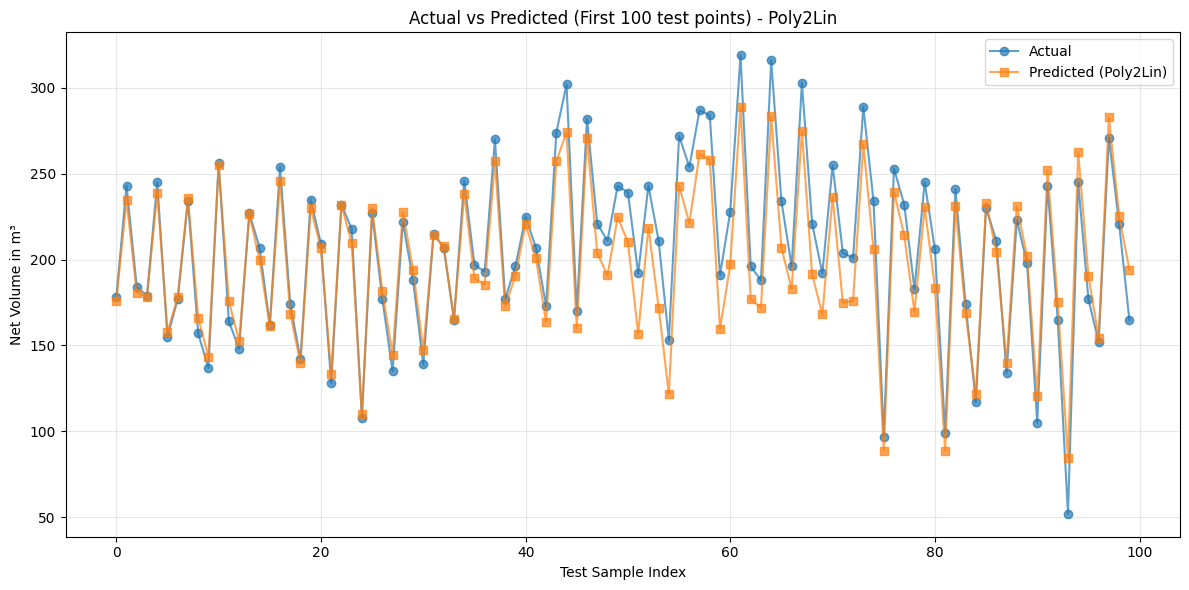

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Add XGBoost
import xgboost as xgb

# --- Feature engineering (unchanged) ---
def create_advanced_features(df):
    df = df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values('Timestamp').reset_index(drop=True)
    df['hour_of_day'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['day_of_month'] = df['Timestamp'].dt.day
    df['week_of_year'] = df['Timestamp'].dt.isocalendar().week
    df['month_of_year'] = df['Timestamp'].dt.month
    df['quarter'] = df['Timestamp'].dt.quarter
    for period, col in [(24, 'hour_of_day'), (7, 'day_of_week'), (12, 'month_of_year'), (52, 'week_of_year')]:
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)
    target_col = 'Net Volume in m³'
    for lag in range(1, 7):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    for week in [1, 2, 4]:
        weekly_lag = week * 21
        df[f'lag_week_{week}'] = df[target_col].shift(weekly_lag)
    windows = [3, 6, 9, 21, 42]
    for window in windows:
        df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean().shift(1)
        df[f'rolling_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1)
        df[f'rolling_max_{window}'] = df[target_col].rolling(window=window, min_periods=1).max().shift(1)
        df[f'rolling_min_{window}'] = df[target_col].rolling(window=window, min_periods=1).min().shift(1)
        df[f'rolling_median_{window}'] = df[target_col].rolling(window=window, min_periods=1).median().shift(1)
        df[f'rolling_q75_{window}'] = df[target_col].rolling(window=window, min_periods=1).quantile(0.75).shift(1)
        df[f'rolling_q25_{window}'] = df[target_col].rolling(window=window, min_periods=1).quantile(0.25).shift(1)
        df[f'rolling_trend_{window}'] = (df[f'rolling_mean_{window}'] -
                                        df[target_col].rolling(window=window, min_periods=1).mean().shift(window))
    if 'Work Hours in hr' in df.columns:
        df['work_hours_log'] = np.log1p(df['Work Hours in hr'])
        df['work_hours_sqrt'] = np.sqrt(df['Work Hours in hr'])
        df['work_hours_normalized'] = (df['Work Hours in hr'] - df['Work Hours in hr'].min()) / (df['Work Hours in hr'].max() - df['Work Hours in hr'].min())
        for lag in [1, 3, 7]:
            df[f'work_hours_lag_{lag}'] = df['Work Hours in hr'].shift(lag)
        for window in [3, 7, 21]:
            df[f'work_hours_rolling_mean_{window}'] = df['Work Hours in hr'].rolling(window=window, min_periods=1).mean().shift(1)
            df[f'work_hours_rolling_std_{window}'] = df['Work Hours in hr'].rolling(window=window, min_periods=1).std().shift(1)
    academic_features = ['is_semester', 'is_midsem_recess']
    for feature in academic_features:
        if feature in df.columns:
            df[f'{feature}_hour_interaction'] = df[feature] * df['hour_of_day']
            df[f'{feature}_day_interaction'] = df[feature] * df['day_of_week']
            df[f'{feature}_duration'] = df.groupby((df[feature] != df[feature].shift()).cumsum()).cumcount()
    df['is_peak_morning'] = ((df['hour_of_day'] >= 8) & (df['hour_of_day'] <= 10)).astype(int)
    df['is_peak_evening'] = ((df['hour_of_day'] >= 16) & (df['hour_of_day'] <= 18)).astype(int)
    df['is_night'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] <= 5)).astype(int)
    df['is_business_hours'] = ((df['hour_of_day'] >= 8) & (df['hour_of_day'] <= 17)).astype(int)
    if 'Work Hours in hr' in df.columns:
        df['consumption_per_work_hour'] = df[target_col] / (df['Work Hours in hr'] + 1)
        df['consumption_efficiency'] = df[target_col] / (df['Work Hours in hr'].rolling(window=7, min_periods=1).mean() + 1)
    for window in [3, 7, 21]:
        df[f'volatility_{window}'] = df[target_col].rolling(window=window, min_periods=1).std().shift(1) / (df[target_col].rolling(window=window, min_periods=1).mean().shift(1) + 1)
        df[f'change_rate_{window}'] = (df[target_col] - df[target_col].shift(window)) / (df[target_col].shift(window) + 1)
    return df

# Load data
df = df.copy()
df_enhanced = create_advanced_features(df)
df_enhanced = df_enhanced.dropna()

target_col = 'Net Volume in m³'
feature_cols = [col for col in df_enhanced.columns if col not in ['Timestamp', target_col]]
numeric_features = df_enhanced[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
X = df_enhanced[numeric_features].values
y = df_enhanced[target_col].values

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler_X = RobustScaler()
scaler_y = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# --- Train models ---
models = {}
predictions = {}

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train_scaled)
models['DecisionTree'] = dt
predictions['DecisionTree'] = dt.predict(X_test_scaled)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train_scaled)
models['RandomForest'] = rf
predictions['RandomForest'] = rf.predict(X_test_scaled)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train_scaled, y_train_scaled)
models['GradientBoosting'] = gb
predictions['GradientBoosting'] = gb.predict(X_test_scaled)

# SVR (RBF kernel)
svr = SVR(kernel='rbf', C=10, epsilon=0.01, gamma='scale')
svr.fit(X_train_scaled, y_train_scaled)
models['SVR'] = svr
predictions['SVR'] = svr.predict(X_test_scaled)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_scaled)
models['LinearRegression'] = lr
predictions['LinearRegression'] = lr.predict(X_test_scaled)

# Poly2Lin (Polynomial Regression degree 2)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
plr = LinearRegression()
plr.fit(X_train_poly, y_train_scaled)
models['Poly2Lin'] = plr
predictions['Poly2Lin'] = plr.predict(X_test_poly)

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_scaled, y_train_scaled)
models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_model.predict(X_test_scaled)

# --- Inverse scaling and compute MAPE ---
model_scores = {}
for name, pred_scaled in predictions.items():
    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
    mape = mean_absolute_percentage_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    model_scores[name] = {'MAPE': mape, 'RMSE': rmse, 'y_pred': pred}
    print(f"{name} - MAPE: {mape:.4f} ({mape*100:.2f}%), RMSE: {rmse:.4f}")

# --- Filter out extreme MAPE values (>200%) ---
filtered_mapes = {}
for name, result in model_scores.items():
    mape_per_sample = np.abs((y_test - result['y_pred']) / np.clip(np.abs(y_test), 1e-8, None))
    reasonable_mape = mape_per_sample[(mape_per_sample < 2.0) & (mape_per_sample >= 0)]
    filtered_mapes[name] = {
        'mean_mape': np.mean(reasonable_mape),
        'median_mape': np.median(reasonable_mape),
        'count': len(reasonable_mape)
    }
    print(f"{name} - Filtered Mean MAPE: {np.mean(reasonable_mape)*100:.2f}%, Median: {np.median(reasonable_mape)*100:.2f}%, Used: {len(reasonable_mape)}")

# --- Find best model (lowest filtered mean MAPE) ---
best_model_name = min(filtered_mapes, key=lambda x: filtered_mapes[x]['mean_mape'])
best_pred = model_scores[best_model_name]['y_pred']

print(f"\nBest Model: {best_model_name} (Filtered Mean MAPE: {filtered_mapes[best_model_name]['mean_mape']*100:.2f}%)")

# --- Plot actual vs predicted for best model ---
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual', marker='o', alpha=0.7)
plt.plot(best_pred[:100], label=f'Predicted ({best_model_name})', marker='s', alpha=0.7)
plt.title(f'Actual vs Predicted (First 100 test points) - {best_model_name}')
plt.xlabel('Test Sample Index')
plt.ylabel('Net Volume in m³')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.4 MB/s eta 0:00:00
